## **ECOM90025 ADA Tutorial 10** ##


In [ ]:
# library packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz, plot_tree
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
import xgboost as xgb
import shap
import requests
from PIL import Image
from io import BytesIO


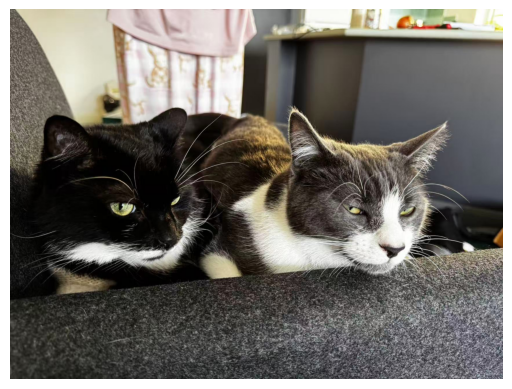

In [ ]:
# Bad cat gang
# https://drive.google.com/file/d/1OWqdefk00j-SV96Q8Vt9h4_9lY4J20R9/view?usp=drive_link
url = 'https://drive.google.com/uc?id=1OWqdefk00j-SV96Q8Vt9h4_9lY4J20R9'

# Download and open the image
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# my state this week with 2 mid exams
# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

###**The Titanic Data Set**

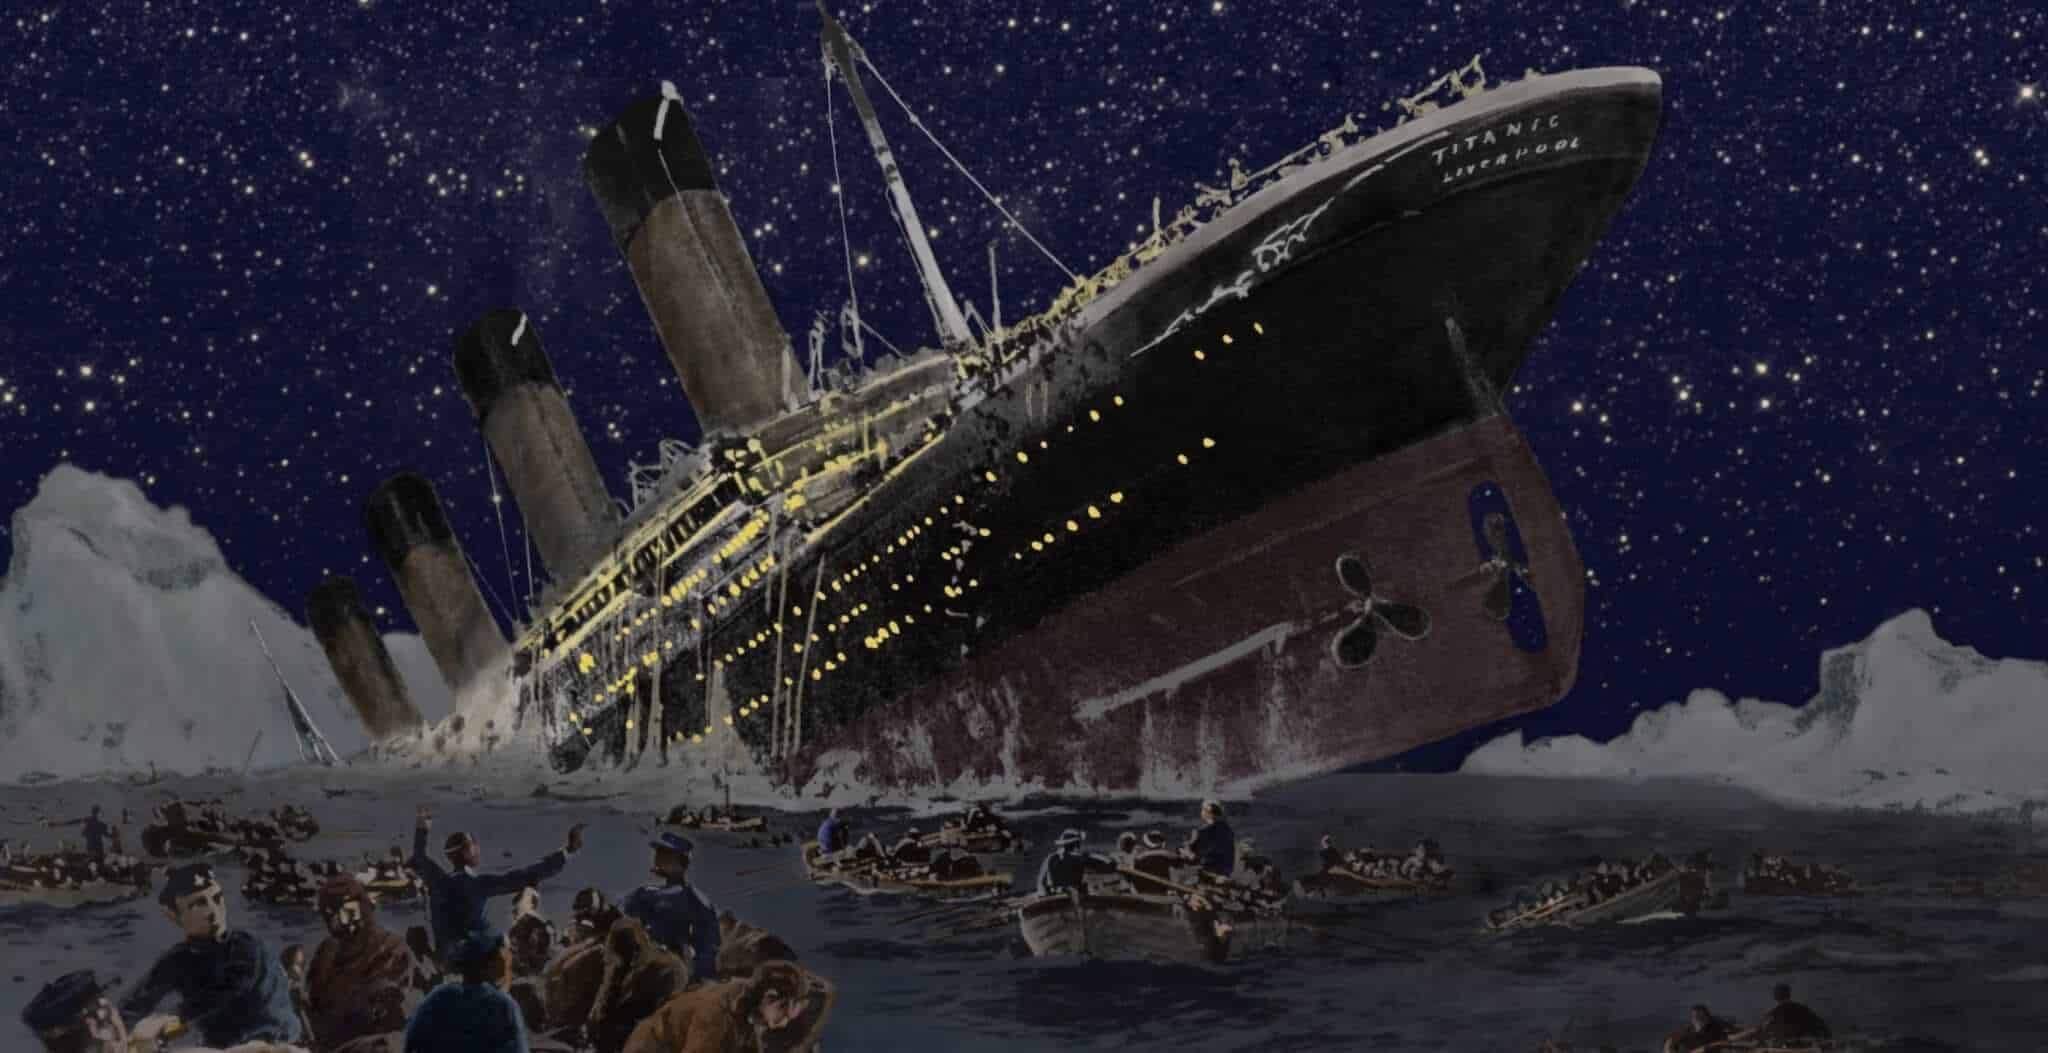

In [ ]:
df_train = pd.read_csv("https://www.dropbox.com/s/i0kduxato6oxwyg/train.csv?dl=1")
df_train

# row: each row correspond to one passenger on the titanic
# survived: binary variable 1 = survived, 0 = not
# PclassL: ticket class (upper=1, middle=2, lower=3), this is a social economic proxy
# name, sex, age as expected
# Sibsp: number of sibling/spouse on the same ship
# Parch: number of parent/childer on the same ship
# Ticket, fare and cabin is as what you expected
# embark: where do they get onto the ship (S = Southampton, C= cherbourg, Q= Queenstown)

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [ ]:
# what are some of the missing informations
df_train.isnull().sum()
# we are saying age and cabin are those with lots of missing values (which make sense thinking about those who are in the third class and did not survive)
# cabin and embark is not a really huge problem because they are categorical values NaN can be treated as a category
# but we need to think about a way to deal with the age missing values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# Create a copy of the training data to avoid modifying the original
df_train_clean = df_train.copy()

# Create age_missing indicator
df_train_clean['age_missing'] = df_train_clean['Age'].isna().astype(int)

# Fill missing ages with median age
median_age = df_train_clean['Age'].median()
df_train_clean['Age'] = df_train_clean['Age'].fillna(median_age)

###**Preliminary Analysis**

**Main question: What predicts survival in the Titanic catastrophy?**

In [ ]:
# Let's first roughly see how gender determines the survival
# Gender: total passengers and survivors
gender_summary = (
    df_train_clean.groupby('Sex')
            .agg(passengers=('PassengerId', 'count'),
                 survivors=('Survived', 'sum'))
            .assign(survival_rate=lambda d: d['survivors'] / d['passengers'])
)
print("By gender:\n", gender_summary, "\n")

By gender:
         passengers  survivors  survival_rate
Sex                                         
female         314        233       0.742038
male           577        109       0.188908 



In [ ]:
# Let's then roughly see how the cabin class determines the survival
# Class (1/2/3): total passengers and survivors
class_summary = (
    df_train_clean.groupby('Pclass')
            .agg(passengers=('PassengerId', 'count'),
                 survivors=('Survived', 'sum'))
            .assign(survival_rate=lambda d: d['survivors'] / d['passengers'])
            .sort_index()
)
print("By class:\n", class_summary)

By class:
         passengers  survivors  survival_rate
Pclass                                      
1              216        136       0.629630
2              184         87       0.472826
3              491        119       0.242363


In [ ]:
# Logit model
y, X = patsy.dmatrices('Survived ~ Sex + Age + age_missing -1', data=df_train_clean, return_type='dataframe')
# survival on sex, age, age missing and we drop intercept as required by the package

logit = LogisticRegression(max_iter=1000)
logit.fit(X, y.values.ravel())

# generate prediction according to the model fit
y_pred = logit.predict(X)

# table of prediction accuracy
ct = pd.crosstab(y['Survived'], y_pred, rownames=['Actual'], colnames=['Predicted'])
print(ct)

Predicted  0.0  1.0
Actual             
0.0        468   81
1.0        109  233


In [ ]:
# if we add in cabin class
y, X = patsy.dmatrices('Survived ~ Sex + Age + Pclass + age_missing -1', data=df_train_clean, return_type='dataframe') # type: ignore

logit = LogisticRegression(max_iter=1000)
logit.fit(X, y.values.ravel())

y_pred = logit.predict(X)
ct = pd.crosstab(y['Survived'], y_pred, rownames=['Actual'], colnames=['Predicted'])
print(ct)

Predicted  0.0  1.0
Actual             
0.0        469   80
1.0         98  244


### **Trees/Pruned Trees**


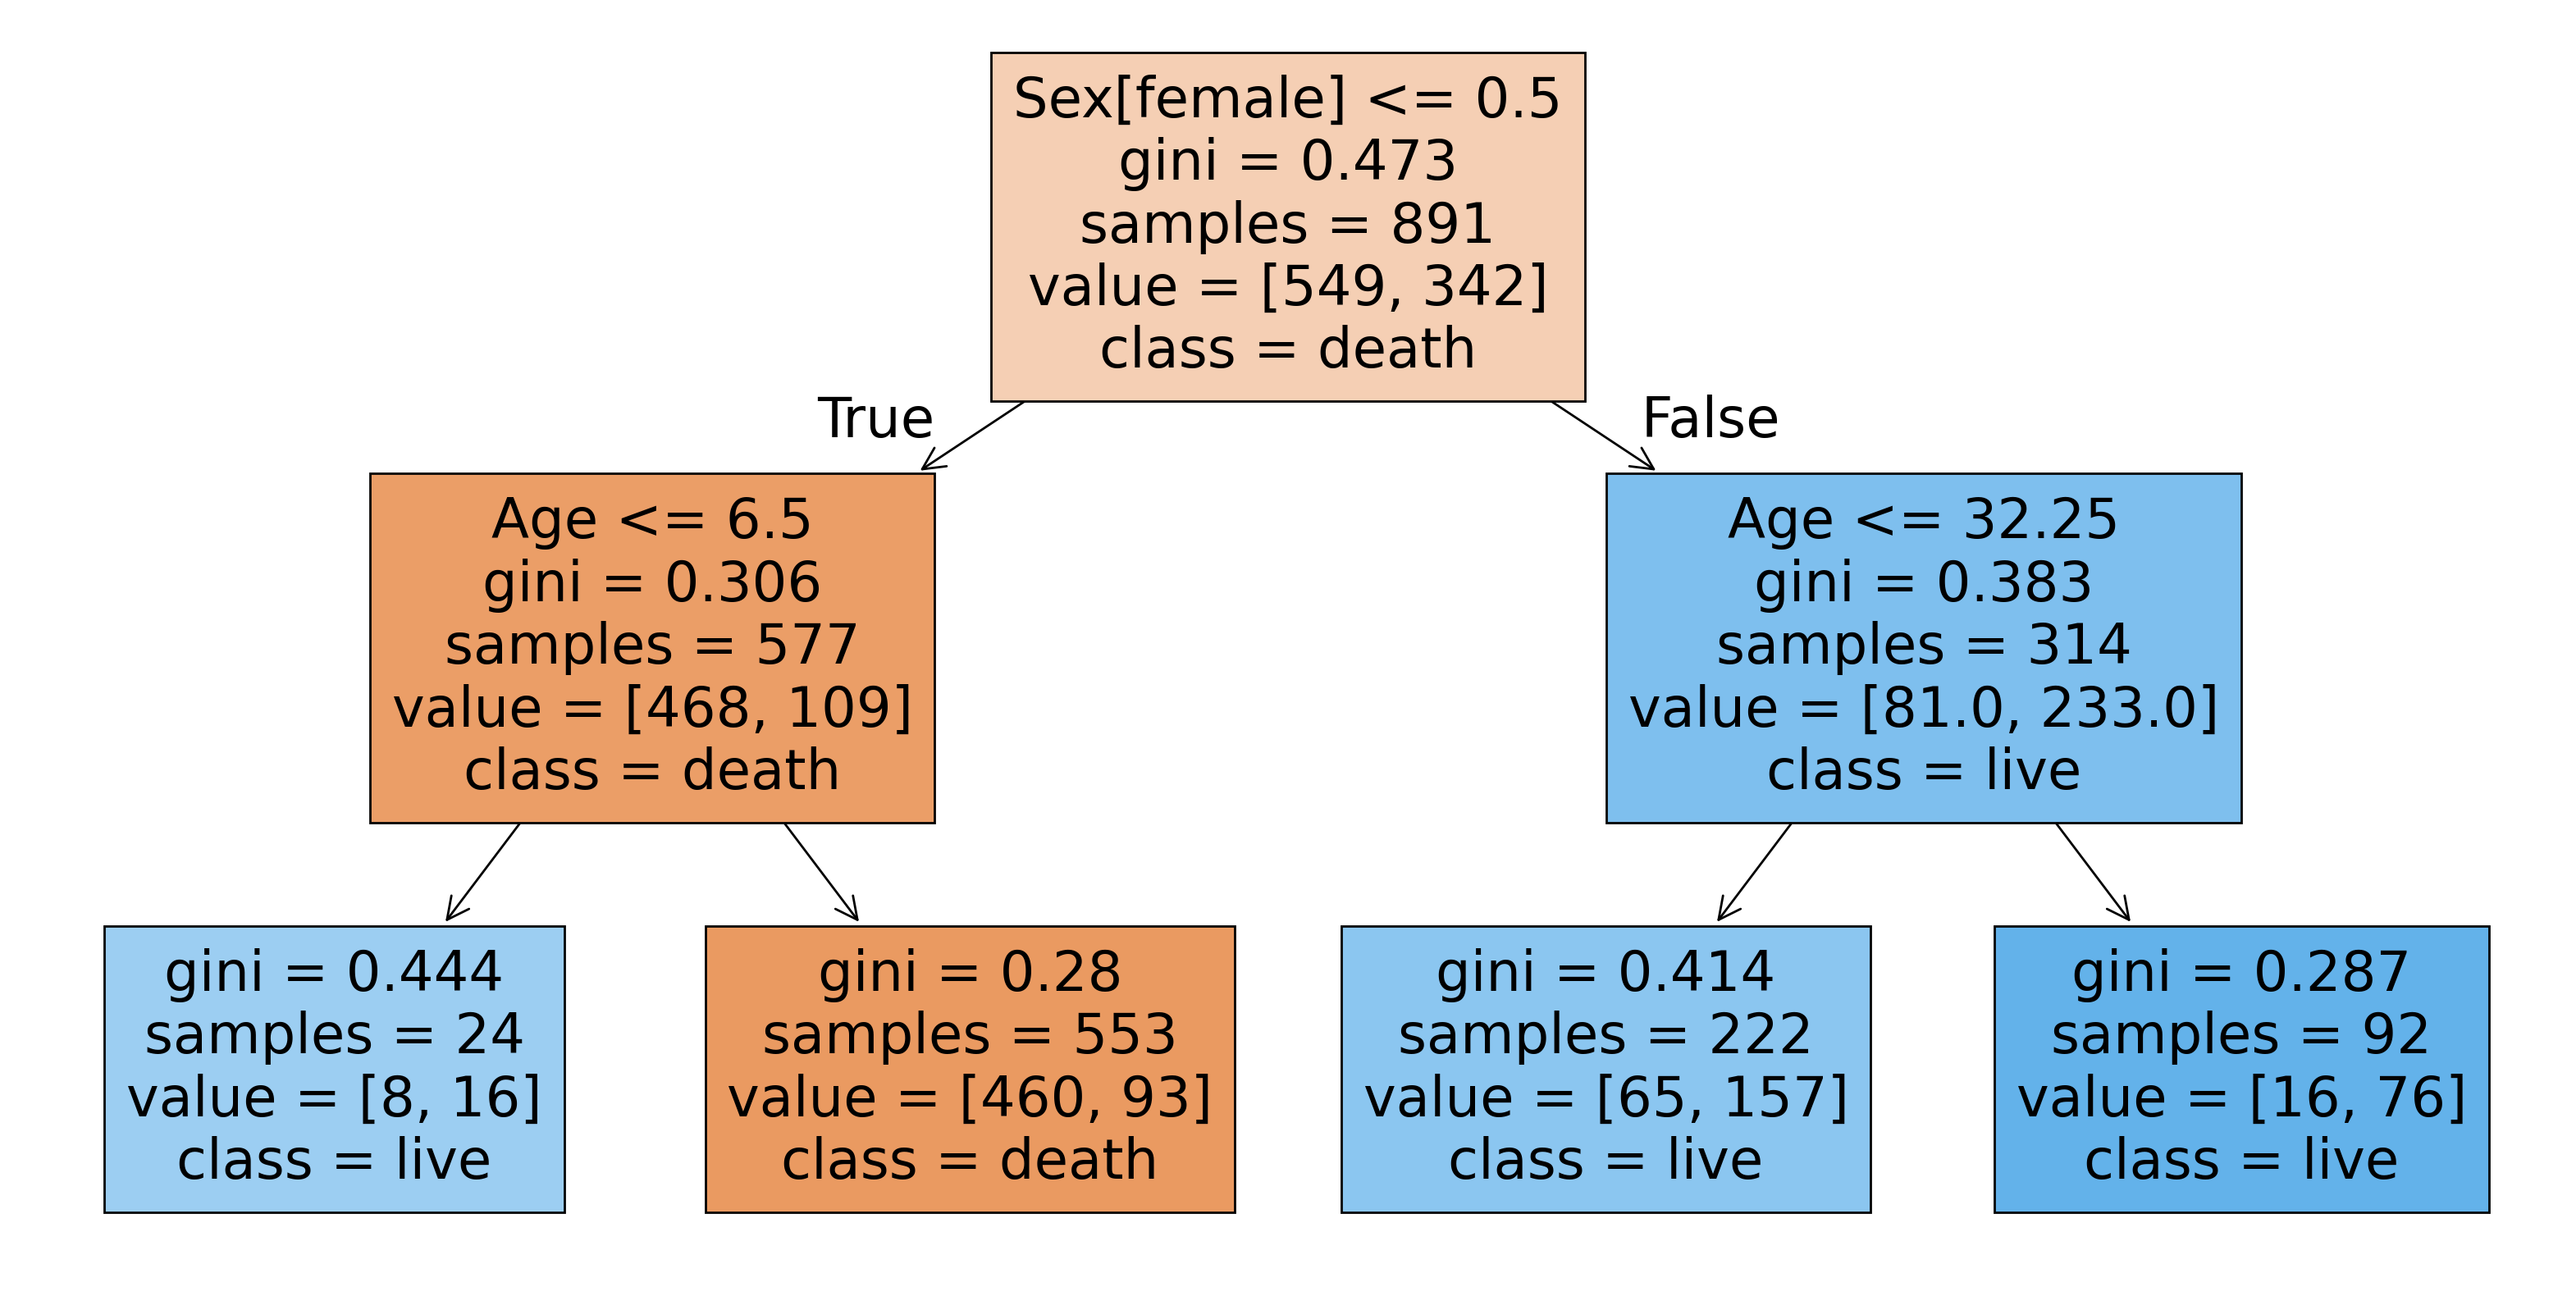

In [ ]:
# we generate the same matrix for training
y, X = patsy.dmatrices('Survived ~ Sex + Age + age_missing -1', data=df_train_clean, return_type='dataframe') # type: ignore

# we call a single decision tree and manually set the depth as two
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)

# Plot the tree to see its keu characteristics
plt.figure(figsize=(20, 10), dpi=200)
plot_tree(clf, feature_names=X.columns, class_names=['death', 'live'], filled=True) # type: ignore
plt.show()

# Let's see what the graph is doing
# The first layer separates the gender (straight away male/female) - all female survive, all male die
# The second layer split age, female group split at 32.25, male group split at 6.5
# both female group predicted to live and male only age smaller than 6.5 predicted to live
# value: numbder of [live/death] in each node

In [ ]:
# we now try to prune the tree
# fit an unpruned tree first
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Create a path of pruning alpha
# this pruning alpha is basically goving backward with trees, how much do I cut to minimize the loss
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

# but when do I stop cutting - need to loop through alpha
scores = []
for alpha in ccp_alphas:
    if alpha <= 0:
        scores.append(0)  # Give a dummy score
        continue  # Skip non-positive alphas
    tree = DecisionTreeClassifier(ccp_alpha=alpha)
    score = np.mean(cross_val_score(tree, X, y, cv=3))  # Using 3-fold CV
    scores.append(score)

# generaate the best alpha that maximizze the score
best_alpha = ccp_alphas[np.argmax(scores)]
best_alpha

np.float64(0.01283013123197213)

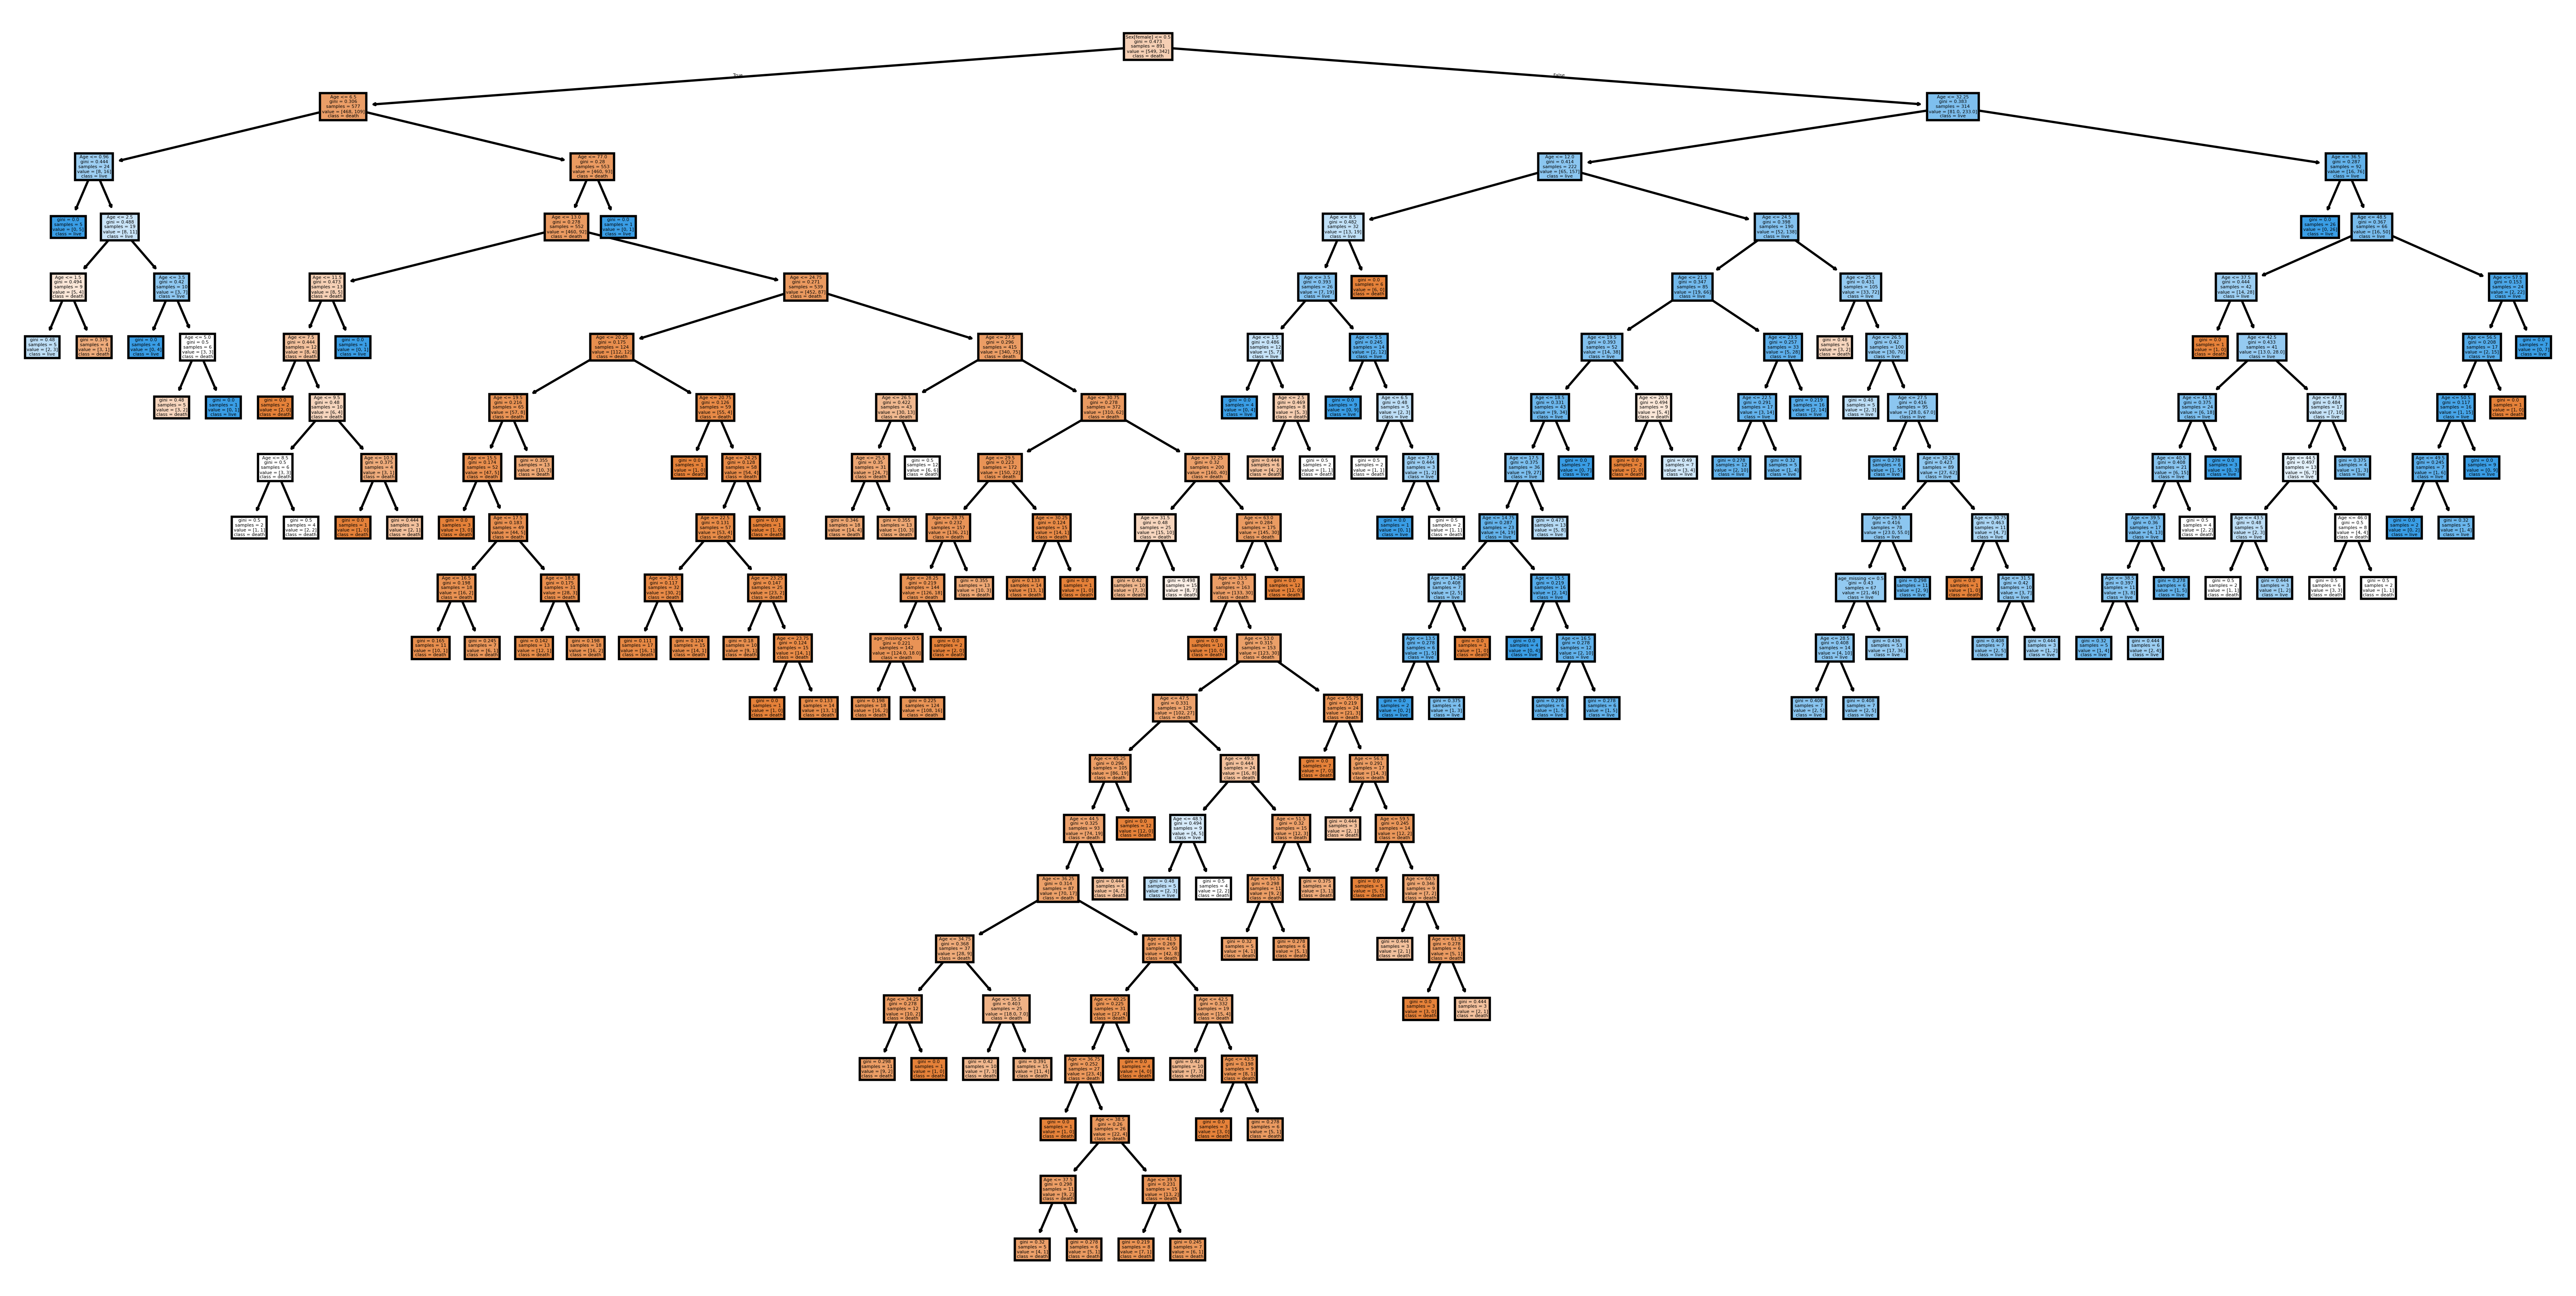

In [ ]:
# train the pruned tree using the optimal alpha
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
pruned_tree.fit(X, y)

# Plot the pruned tree
plt.figure(figsize=(20, 10), dpi=400)
plot_tree(clf, feature_names=X.columns, class_names=['death', 'live'], filled=True) # type: ignore
plt.show()

In [ ]:
# print out the prediction matrix
y_pred = pruned_tree.predict(X)
ct = pd.crosstab(y['Survived'], y_pred, rownames=['Actual'], colnames=['Predicted'])
print(ct)

# the same result as simple logistic
# note this is just simple in-sample, we will still need to consider overfitting issue

Predicted  0.0  1.0
Actual             
0.0        468   81
1.0        109  233


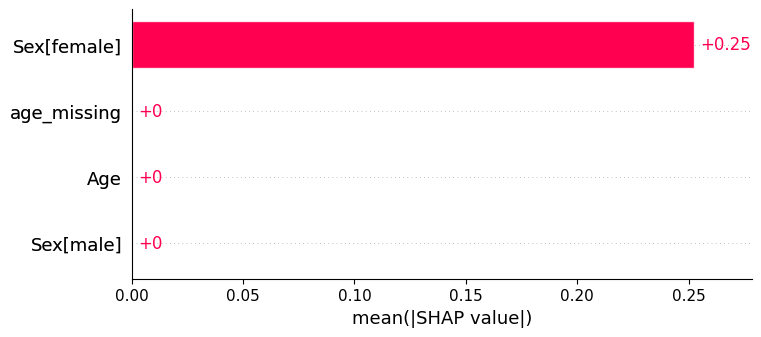

In [ ]:
# SHAP explanation
# relative importance of the features
# SHAP value: after adding in this characteristics for a particularindividual, how much the prediction change
# mean SHAPL average across individuals
explainer = shap.TreeExplainer(pruned_tree)
shap_values = explainer(X)
shap.plots.bar(shap_values[:, :, 1])
# what does this show, after pruning, this tree almost only uses information of gender

###**Random Forest**

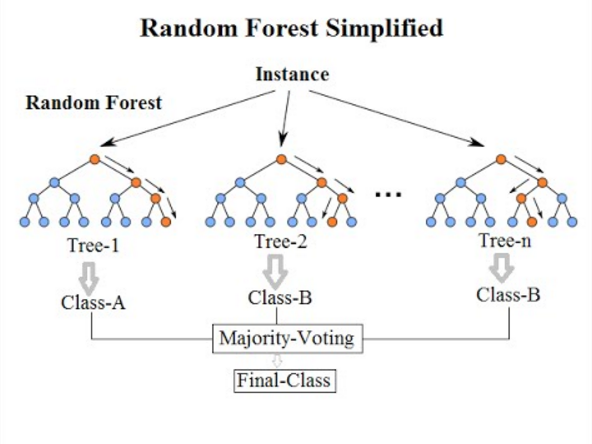

**tree voting (LOTR-In case you have never seen how tree votes)**


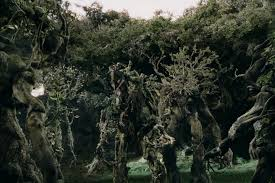

Predicted  0.0  1.0
Actual             
0.0        481   68
1.0         93  249


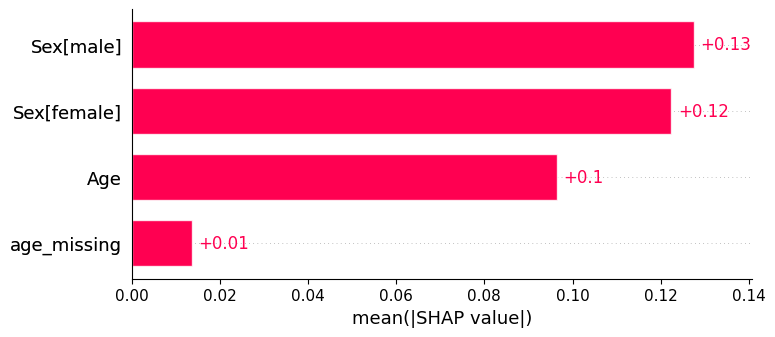

In [ ]:
# where does randomness in random forest come from?
# random subsection of data : bootstrap dataset (draw n rows with replacement)
# random subsection of features in each node for each tree

# why does random forest fit better in sample
# "dont put egg in the same basket"
# try to conver impacts of all feature

# why does random forst reduce overfitting
# cancel out noises: each tree overfit differently, and we balance it out
# randomness: prevent sticking onto the same thing forever
# OOB training: for bootstrap we have rows never selected can be used as Out of sample

rf_clf = RandomForestClassifier()
rf_clf.fit(X, y.values.ravel())

# prediction accuracy
y_pred = rf_clf.predict(X)
ct = pd.crosstab(y['Survived'], y_pred, rownames=['Actual'], colnames=['Predicted'])
print(ct)

# SHAP explnation
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X)
shap.plots.bar(shap_values[:, :, 1])

Predicted  0.0  1.0
Actual             
0.0        513   36
1.0         71  271


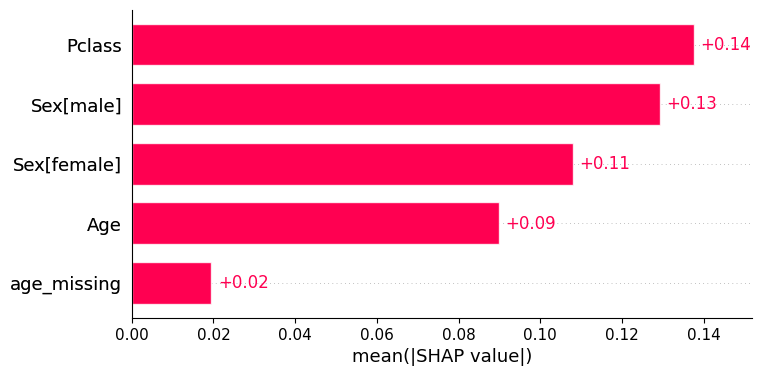

In [ ]:
# we can try fit another with the cabin class included
y2, X2 = patsy.dmatrices('Survived ~ Sex + Age + Pclass + age_missing -1', data=df_train_clean, return_type='dataframe') # type: ignore

# initiate RF
rf_clf2 = RandomForestClassifier()
rf_clf2.fit(X2, y2.values.ravel())

# prediction accuracy
y_pred2 = rf_clf2.predict(X2)
ct = pd.crosstab(y2['Survived'], y_pred2, rownames=['Actual'], colnames=['Predicted'])
print(ct)

# SHAP explnation
explainer = shap.TreeExplainer(rf_clf2)
shap_values = explainer(X2)
shap.plots.bar(shap_values[:, :, 1])

###**Compare OOS prediction results**

<img src="https://www.dropbox.com/scl/fi/fjm09qrnp5ai4bbetiwsk/titanic.png?rlkey=2rwqwl0yb3qymsvspaw4y8ae3&st=xvad6uck&dl=1"/>
